# Project GPU
Mikołaj Rosowski (165 313)

In [1]:
%pip install torch==2.9.0 torchaudio==2.9.0 torchcodec==0.9.1 torchao==0.14.0 executorch==1.0.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 77.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 57.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 64.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 543.0/543.0 kB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 70.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.1/118.1 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 4.2 

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchaudio
import torchaudio.functional as AF
from torch.utils.data import DataLoader, random_split, Dataset
from torchaudio.datasets import SPEECHCOMMANDS
from torchsummary import summary

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np

import datetime
import os
import shutil
import zipfile
from pathlib import Path

In [3]:
print(f"Torch version: {torch.__version__}")
print(f"TorchAudio version: {torchaudio.__version__}")

Torch version: 2.9.0+cu126
TorchAudio version: 2.9.0+cu126


In [4]:
sr = 16000
n_mels = 40
n_fft = 512
hop_len = 256
batch_size = 64
epochs = 15
lr = 0.0005
seed = 420
train = True

In [5]:
model_name = "tiny"
model_normal = f"{model_name}.pt"
model_quant = f"{model_name}.pte"

In [6]:
torch.manual_seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


In [7]:
root = Path("./sc_data")
root.mkdir(parents=True, exist_ok=True)

train_set = SPEECHCOMMANDS(root, download=True, subset="training")
test_set = SPEECHCOMMANDS(root, download=True, subset="testing")
val_set = SPEECHCOMMANDS(root, download=True, subset="validation")

100%|██████████| 2.26G/2.26G [01:43<00:00, 23.5MB/s]


In [8]:
train_size = len(train_set)
calib_size = int(train_size * 0.1)
train_size -= calib_size

train_sset, calib_sset = random_split(train_set, [train_size, calib_size], generator=torch.Generator().manual_seed(seed))

In [9]:
all_labels = sorted(list({Path(p).parent.name for p in train_set._walker}))

labels = all_labels.copy()
if "unknown" not in labels:
  labels.append("unknown")
if "silence" not in labels:
  labels.append("silence")

classes = len(labels)

label_to_idx = {l: i for i, l in enumerate(labels)}
print(f"Labels: {labels}")
print(f"Number of classes: {classes}")

Labels: ['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero', 'unknown', 'silence']
Number of classes: 37


In [10]:
def preprocess(
    dataset: SPEECHCOMMANDS,
    subset: str,
    cache_dir: str | Path = "cache",
    archive: bool = False,
):
  cache_dir = Path(cache_dir) / subset
  cache_dir.mkdir(parents=True, exist_ok=True)

  for i in tqdm(range(len(dataset)), desc=f"Preprocessing {subset}"):
    cache_file = cache_dir / f"{i:05}.pt"
    if cache_file.exists():
      continue

    mel_spectrogram = torchaudio.transforms.MelSpectrogram(
      sample_rate=sr,
      n_fft=n_fft,
      win_length=n_fft,
      hop_length=hop_len,
      n_mels=n_mels,
      # normalized=True
    ).to(device)

    waveform, sample_rate, label, speaker_id, utterance_number = dataset[i]

    # Resample
    if sample_rate != sr:
      waveform = AF.resample(waveform, sample_rate, sr)

    # Pad / Trim
    if waveform.shape[1] < sr:
      waveform = F.pad(waveform, (0, sr - waveform.shape[1]))
    elif waveform.shape[1] > sr:
      waveform = waveform[:, :sr]

    # Ensure shape
    if len(waveform.shape) == 1:
      waveform = waveform.unsqueeze(0)

    #Dbg print raw waveform
    # if i == 1:
    #   print(f"Raw waveform: {waveform}")

    # Move to device
    waveform = waveform.to(device)

    # Mel spectogram
    mel_spec = mel_spectrogram(waveform)

    # Convert to decibel (log) scale
    mel_spec = torchaudio.transforms.AmplitudeToDB()(mel_spec)

    # Trim unused dimension
    if mel_spec.shape[0] == 1:
      mel_spec = mel_spec.squeeze(0)

    torch.save({"mel_spec": mel_spec, "label": label_to_idx[label]}, cache_file)

  # Export directory as zip
  if archive:
    shutil.make_archive(cache_dir, "zip", cache_dir)


In [11]:
opts = [
    {"dataset": train_sset, "subset": "train"},
    {"dataset": calib_sset, "subset": "calib"},
    {"dataset": test_set, "subset": "test"},
    {"dataset": val_set, "subset": "val"},
]

for opt in opts:
  preprocess(**opt)

Preprocessing train:   0%|          | 0/76359 [00:00<?, ?it/s]

Preprocessing calib:   0%|          | 0/8484 [00:00<?, ?it/s]

Preprocessing test:   0%|          | 0/11005 [00:00<?, ?it/s]

Preprocessing val:   0%|          | 0/9981 [00:00<?, ?it/s]

In [12]:
class MelDataset(Dataset):
  def __init__(self, subset: str, cache_dir: str | Path = "cache"):
    self.cache_dir = Path(cache_dir) / subset
    self.files = list(self.cache_dir.glob("*.pt"))

  def __len__(self):
    return len(self.files)

  def __getitem__(self, index):
    cache_file = self.files[index]
    data = torch.load(cache_file)
    return data["mel_spec"], data["label"]

def collate_fn(batch):
  mels, labels = zip(*batch)
  return torch.stack(mels), torch.tensor(labels, dtype=torch.long)

In [13]:
train_loader = DataLoader(
  MelDataset("train"),
  batch_size=batch_size,
  shuffle=True,
  collate_fn=collate_fn,
)

test_loader = DataLoader(
  MelDataset("test"),
  batch_size=batch_size,
  shuffle=False,
  collate_fn=collate_fn,
)

val_loader = DataLoader(
  MelDataset("val"),
  batch_size=batch_size,
  shuffle=False,
  collate_fn=collate_fn,
)

calib_loader = DataLoader(
  MelDataset("calib"),
  batch_size=batch_size,
  shuffle=True,
  collate_fn=collate_fn,
)

Samples shape: torch.Size([64, 40, 63])
Labels shape: torch.Size([64])
[[-47.564896 -43.824524 -46.82068  ... -42.319603 -39.18533  -36.70658 ]
 [-35.022408 -39.183075 -32.752388 ... -34.09823  -25.4375   -25.125532]
 [-36.35391  -40.73576  -31.748798 ... -30.934446 -24.088646 -26.161568]
 ...
 [-44.867447 -44.87303  -45.007584 ... -41.91633  -43.70632  -41.148277]
 [-44.924744 -46.425915 -44.646667 ... -43.146347 -45.71376  -44.349983]
 [-48.423462 -51.89331  -49.474937 ... -47.80334  -46.579384 -47.98531 ]]


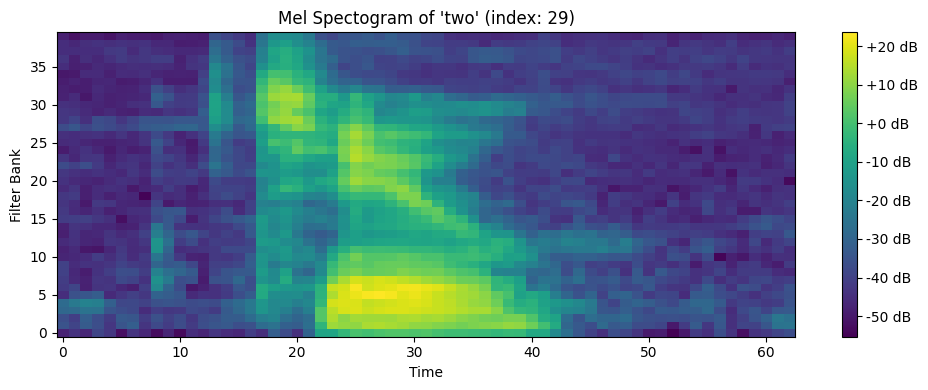

In [14]:
samples, label_idxs = next(iter(train_loader))
print(f"Samples shape: {samples.shape}")
print(f"Labels shape: {label_idxs.shape}")

spectogram = samples[0].cpu().numpy()
label = label_idxs[0].item()
label_name = labels[label]

print(spectogram)

plt.figure(figsize=(10, 4))

plt.imshow(
  spectogram,
  aspect="auto",
  origin="lower",
  interpolation="nearest",
)
plt.colorbar(format="%+2.0f dB")
plt.title(f"Mel Spectogram of '{label_name}' (index: {label})")
plt.xlabel("Time")
plt.ylabel("Filter Bank")
plt.tight_layout()
plt.show()


In [15]:
class ConvBnReLU(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False)
    self.bn = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.conv(x)
    x = self.bn(x)
    x = self.relu(x)
    return x

class TinyModel(nn.Module):
  def __init__(self):
    super().__init__()

    self.bl1 = ConvBnReLU(1, 12)
    self.bl2 = ConvBnReLU(12, 24)
    self.bl3 = ConvBnReLU(24, 32)
    self.bl4 = ConvBnReLU(32, 32)
    self.bl5 = ConvBnReLU(32, 32)

    self.avg = nn.AvgPool2d(2)
    self.fc = nn.Linear(32, classes)

  def forward(self, x):
    x = x.unsqueeze(1)

    x = self.bl1(x)
    x = self.avg(x)

    x = self.bl2(x)
    x = self.avg(x)

    x = self.bl3(x)
    x = self.avg(x)

    x = self.bl4(x)
    x = self.avg(x)

    x = self.bl5(x)
    x = self.avg(x)

    x = torch.flatten(x, 1)
    x = self.fc(x)
    return x

model = TinyModel().to(device)
summary(model, (40, 63))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 40, 63]             108
       BatchNorm2d-2           [-1, 12, 40, 63]              24
              ReLU-3           [-1, 12, 40, 63]               0
        ConvBnReLU-4           [-1, 12, 40, 63]               0
         AvgPool2d-5           [-1, 12, 20, 31]               0
            Conv2d-6           [-1, 24, 20, 31]           2,592
       BatchNorm2d-7           [-1, 24, 20, 31]              48
              ReLU-8           [-1, 24, 20, 31]               0
        ConvBnReLU-9           [-1, 24, 20, 31]               0
        AvgPool2d-10           [-1, 24, 10, 15]               0
           Conv2d-11           [-1, 32, 10, 15]           6,912
      BatchNorm2d-12           [-1, 32, 10, 15]              64
             ReLU-13           [-1, 32, 10, 15]               0
       ConvBnReLU-14           [-1, 32,

In [16]:
optim = torch.optim.Adam(model.parameters(), lr=lr)
crit = nn.CrossEntropyLoss()

In [17]:
def train(model, loader, optim, crit, device):
  model.train()
  total_loss = 0.0
  total_correct = 0
  total = 0
  for batch_idx, (x, y) in tqdm(enumerate(loader), desc="Training", total=len(loader)):
    x = x.to(device)
    y = y.to(device)
    logits = model(x)
    loss = crit(logits, y)
    optim.zero_grad()
    loss.backward()
    optim.step()
    total_loss += loss.item() * x.size(0)
    pred = logits.argmax(dim=1)
    total_correct += pred.eq(y).sum().item()
    total += x.size(0)

  loss = total_loss / total
  acc = total_correct / total
  print(f"Loss: {loss:.4f}, Accuracy: {(acc*100):.2f}%")
  return total_loss / total, total_correct / total

In [18]:
def evaluate(model, loader, crit, device):
  model.eval()
  total_loss = 0.0
  total_correct = 0
  total = 0
  with torch.no_grad():
    for batch_idx, (x, y) in tqdm(enumerate(loader), desc="Evaluating", total=len(loader)):
      x = x.to(device)
      y = y.to(device)
      logits = model(x)
      loss = crit(logits, y)
      total_loss += loss.item() * x.size(0)
      pred = logits.argmax(dim=1)
      total_correct += pred.eq(y).sum().item()
      total += x.size(0)
  return total_loss / total, total_correct / total

In [19]:
best_val_acc = 0.0
if train:
  for epoch in range(epochs):
    print(f"Epoch {(epoch + 1):02}:")
    train_loss, train_acc = train(model, train_loader, optim, crit, device)
    val_loss, val_acc = evaluate(model, val_loader, crit, device)

    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {(val_acc*100):.2f}%")
    if val_acc > best_val_acc:
      best_val_acc = val_acc
      torch.save(model.state_dict(), model_normal)

Epoch 01:


Training:   0%|          | 0/1194 [00:00<?, ?it/s]

Loss: 1.7068, Accuracy: 59.23%


Evaluating:   0%|          | 0/156 [00:00<?, ?it/s]

Val Loss: 0.9262, Val Accuracy: 74.53%
Epoch 02:


Training:   0%|          | 0/1194 [00:00<?, ?it/s]

Loss: 0.5842, Accuracy: 85.04%


Evaluating:   0%|          | 0/156 [00:00<?, ?it/s]

Val Loss: 0.4993, Val Accuracy: 85.54%
Epoch 03:


Training:   0%|          | 0/1194 [00:00<?, ?it/s]

Loss: 0.4314, Accuracy: 88.10%


Evaluating:   0%|          | 0/156 [00:00<?, ?it/s]

Val Loss: 0.3642, Val Accuracy: 89.38%
Epoch 04:


Training:   0%|          | 0/1194 [00:00<?, ?it/s]

Loss: 0.3646, Accuracy: 89.65%


Evaluating:   0%|          | 0/156 [00:00<?, ?it/s]

Val Loss: 0.3465, Val Accuracy: 89.61%
Epoch 05:


Training:   0%|          | 0/1194 [00:00<?, ?it/s]

Loss: 0.3263, Accuracy: 90.53%


Evaluating:   0%|          | 0/156 [00:00<?, ?it/s]

Val Loss: 0.3179, Val Accuracy: 90.56%
Epoch 06:


Training:   0%|          | 0/1194 [00:00<?, ?it/s]

Loss: 0.2996, Accuracy: 91.19%


Evaluating:   0%|          | 0/156 [00:00<?, ?it/s]

Val Loss: 0.3580, Val Accuracy: 89.65%
Epoch 07:


Training:   0%|          | 0/1194 [00:00<?, ?it/s]

Loss: 0.2818, Accuracy: 91.64%


Evaluating:   0%|          | 0/156 [00:00<?, ?it/s]

Val Loss: 0.3150, Val Accuracy: 90.52%
Epoch 08:


Training:   0%|          | 0/1194 [00:00<?, ?it/s]

Loss: 0.2624, Accuracy: 92.25%


Evaluating:   0%|          | 0/156 [00:00<?, ?it/s]

Val Loss: 0.3223, Val Accuracy: 90.66%
Epoch 09:


Training:   0%|          | 0/1194 [00:00<?, ?it/s]

Loss: 0.2495, Accuracy: 92.54%


Evaluating:   0%|          | 0/156 [00:00<?, ?it/s]

Val Loss: 0.2701, Val Accuracy: 92.13%
Epoch 10:


Training:   0%|          | 0/1194 [00:00<?, ?it/s]

Loss: 0.2376, Accuracy: 92.93%


Evaluating:   0%|          | 0/156 [00:00<?, ?it/s]

Val Loss: 0.3051, Val Accuracy: 90.63%
Epoch 11:


Training:   0%|          | 0/1194 [00:00<?, ?it/s]

Loss: 0.2279, Accuracy: 93.18%


Evaluating:   0%|          | 0/156 [00:00<?, ?it/s]

Val Loss: 0.2798, Val Accuracy: 91.31%
Epoch 12:


Training:   0%|          | 0/1194 [00:00<?, ?it/s]

Loss: 0.2168, Accuracy: 93.38%


Evaluating:   0%|          | 0/156 [00:00<?, ?it/s]

Val Loss: 0.2759, Val Accuracy: 91.82%
Epoch 13:


Training:   0%|          | 0/1194 [00:00<?, ?it/s]

Loss: 0.2086, Accuracy: 93.66%


Evaluating:   0%|          | 0/156 [00:00<?, ?it/s]

Val Loss: 0.2739, Val Accuracy: 91.83%
Epoch 14:


Training:   0%|          | 0/1194 [00:00<?, ?it/s]

Loss: 0.2025, Accuracy: 93.82%


Evaluating:   0%|          | 0/156 [00:00<?, ?it/s]

Val Loss: 0.2647, Val Accuracy: 92.07%
Epoch 15:


Training:   0%|          | 0/1194 [00:00<?, ?it/s]

Loss: 0.1961, Accuracy: 94.08%


Evaluating:   0%|          | 0/156 [00:00<?, ?it/s]

Val Loss: 0.2825, Val Accuracy: 91.79%


In [20]:
model = TinyModel().to(device)
model.load_state_dict(torch.load(model_normal, map_location=device))

test_loss, test_acc = evaluate(model, test_loader, crit, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Evaluating:   0%|          | 0/172 [00:00<?, ?it/s]

Test Loss: 0.2893, Test Accuracy: 0.9145


In [21]:
from torch.nn.utils import fuse_conv_bn_eval

def fold_bn(module):
    for name, child in module.named_children():
        if hasattr(child, "conv") and hasattr(child, "bn"):
            # Before fusing, ensure the conv layer doesn't have bias if it was explicitly False
            child.conv = fuse_conv_bn_eval(child.conv, child.bn)
            child.bn = nn.Identity()
        else:
            fold_bn(child)


model = TinyModel().to(device)
model.load_state_dict(torch.load(model_normal, map_location=device))
model.eval()
fold_bn(model)

In [22]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable params {total_params}")

Total trainable params 29265


In [23]:
if train:
  torch.save(model.state_dict(), model_normal)

model_file_size = os.path.getsize(model_normal)
model_file_size_mb = model_file_size / (1024 * 1024)
print(f"Model file size: {model_file_size_mb:.2f} MB")

Model file size: 0.12 MB


# Quantization

In [24]:
from torchao.quantization.pt2e.quantize_pt2e import (
  prepare_qat_pt2e,
  prepare_pt2e,
  convert_pt2e,
)
from executorch.backends.xnnpack.quantizer.xnnpack_quantizer import (
  get_symmetric_quantization_config,
  XNNPACKQuantizer,
)
from torchao.quantization.pt2e import move_exported_model_to_eval
from torchao.quantization.pt2e import allow_exported_model_train_eval
from torchao.quantization.pt2e import move_exported_model_to_train

In [25]:
def evaluate(model, dataloader, device):
    # For nn.Module, move to device and set to eval mode.
    # For GraphModule (exported models), assume it's already on the correct device and in eval mode.
    # The user should ensure GraphModule is prepared (e.g., model.to(device), model.eval())
    # before calling this function.
    if not isinstance(model, torch.fx.GraphModule):
        model.to(device)
        model.eval()

    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            out = model(data)
            pred = out.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += target.size(0)
    return 100. * correct / total

def print_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    print("Size (MB):", os.path.getsize("temp.p")/1e6)
    os.remove("temp.p")

In [26]:
torch._dynamo.reset()
model.eval()
example_inputs = (torch.rand(batch_size, n_mels, 63).to(device),)
dynamic_shapes = (
    {0: torch.export.Dim("batch", min=1, max=batch_size)},  # Batch dim dynamic
)

exported_model = torch.export.export(model, example_inputs, dynamic_shapes=dynamic_shapes).module()

quantizer = XNNPACKQuantizer()
quantizer.set_global(get_symmetric_quantization_config())

prepared_model = prepare_qat_pt2e(exported_model, quantizer)

In [27]:
def calibrate(model, data_loader, device):
    with torch.no_grad():
        for image, target in data_loader:
            image = image.to(device)
            model(image)

calibrate(prepared_model, calib_loader, device)  # Run calibration on calib data
converted_model = convert_pt2e(prepared_model)

In [28]:
try:
    # Check the _guards_fn
    prepared_model._guards_fn(torch.randn(1, n_mels, 63).to(device))
except AssertionError as e:
    print("Guard assertion message:", e)

In [29]:
print_size_of_model(model)
print_size_of_model(converted_model)

Size (MB): 0.122057
Size (MB): 0.152421


In [30]:
fp32_acc = evaluate(model, test_loader, torch.device('cuda'))
int8_acc = evaluate(move_exported_model_to_eval(converted_model).to('cpu'), test_loader, torch.device('cpu'))
print(f'FP32 accuracy: {fp32_acc:.2f}%')
print(f'INT8 accuracy (FX PTQ): {int8_acc:.2f}%')

FP32 accuracy: 91.45%
INT8 accuracy (FX PTQ): 91.16%


In [31]:
import time

def benchmark_model(model, dataloader, device, runs=50):
    if not isinstance(model, torch.fx.GraphModule):
        model.to(device)
        model.eval()

    # Warmup
    with torch.no_grad():
      for i, (data, _) in enumerate(dataloader):
            if i >= 10:
                break
            data = data.to(device)
            _ = model(data)

    # Benchmark
    total = 0.0
    with torch.no_grad():
        for i, (data, _) in enumerate(dataloader):
            if i >= runs:
                break
            data = data.to(device)
            t0 = time.time()
            _ = model(data)
            t1 = time.time()
            total += (t1 - t0)
    return (total / runs) * 1000.0  # ms per batch

In [32]:
fp32_time = benchmark_model(model, test_loader, torch.device('cpu'), runs=300)
int8_time = benchmark_model(move_exported_model_to_eval(converted_model).to('cpu'), test_loader, torch.device('cpu'), runs=300)
print(f'FP32 avg time per batch: {fp32_time:.2f} ms')
print(f'INT8 avg time per batch: {int8_time:.2f} ms')

FP32 avg time per batch: 15.73 ms
INT8 avg time per batch: 31.93 ms


In [33]:
from executorch.backends.xnnpack.partition.xnnpack_partitioner import XnnpackPartitioner
from executorch.exir import to_edge_transform_and_lower
from torch.export import export
from executorch.exir import EdgeCompileConfig, to_edge_transform_and_lower

example_inputs = (torch.rand(1, n_mels, 63),)

edge = to_edge_transform_and_lower(
    export(converted_model.to('cpu'), example_inputs), # Export to CPU
    compile_config=EdgeCompileConfig(_check_ir_validity=False),
    partitioner=[XnnpackPartitioner()]
)

exec_prog = edge.to_executorch()

with open(model_quant, "wb") as file:
    exec_prog.write_to_file(file)

quant_file_size = os.path.getsize(model_quant)
quant_file_size_mb = quant_file_size / (1024 * 1024)
print(f"Quantized model file size: {quant_file_size_mb:.2f} MB")

Quantized model file size: 0.04 MB


# Export to C++

In [36]:
with open("torch_consts_generated.h", "w") as f:
    f.writelines(
        (
            f"/* AUTOMATICALLY GENERATED AT {datetime.datetime.now()} */\n",
            "#ifndef TORCH_CONSTS_GENERATED\n",
            "#define TORCH_CONSTS_GENERATED\n",
        )
    )

    f.writelines(
        (
            "/* CONSTS */\n",
            f"#define SR {sr}\n",
            f"#define N_MELS {n_mels}\n",
            f"#define N_FFT {n_fft}\n",
            "#define N_FRAMES 63\n",
            "#define N_BANKS 40\n"
        )
    )

    f.writelines(
        (
            "/* Labels */\n",
            "static const char* LABELS[] = {\n",
        )
    )
    for label in labels:
        f.write(f'"{label}",\n')
    f.write("};\n")

    f.write("#endif /* TORCH_CONSTS_GENERATED */")

In [37]:
def export_mel(
    cache_dir: str | Path = "cache",
    subset: str = "val",
    outfile: str | Path = "mels.zip",
):
  in_dir = Path(cache_dir) / subset
  files = in_dir.glob("*.pt")

  with zipfile.ZipFile(outfile, "w") as zf:
    for i, p in enumerate(files):
      data = torch.load(p, map_location="cpu")

      mel = data["mel_spec"].detach().to(torch.float32).contiguous().cpu().numpy()
      label = labels[data["label"]]

      arcname = f"{label}/{p.stem}.raw"
      zf.writestr(arcname, mel.astype(np.float32, copy=False).tobytes(order="C"))

export_mel()